In [1]:
import os
import sys
import shutil
import subprocess
import nibabel as nib
from nibabel.orientations import io_orientation, axcodes2ornt


### Setting the rablab qc package path 

In [2]:
try:
    # If running as a script
    rablab_pkg_path = os.path.dirname(os.path.abspath(__file__))
except NameError:
    
    rablab_pkg_path = os.getcwd()
sys.path.append(rablab_pkg_path)
print("RabLab QC path:", rablab_pkg_path)

from mri_slices import MRIQCplots
from fbb_slices import FBBQCplots
from ftp_slices import FTPQCplots
from fdg_slices import FDGQCplots
from slice_selector import SliceSelector

RabLab QC path: /home/mac/pmaiti/Desktop/leads_qc/rablabqc


#### Setting the Paths

In [3]:
tpm_file = os.path.join(rablab_pkg_path,'TPM.nii')

rtpm_path = os.path.join(rablab_pkg_path, 'reslice', 'rT1.nii') # Resliced T1 file to 1mm isotropic resolution
reslice_matlab_script = os.path.join(rablab_pkg_path,'reslice', 'reslice.m')

mask_reslice_matlab_script = os.path.join(rablab_pkg_path, 'reslice', 'mask_reslice.m')

tmp_folder = os.path.join('/shared/petcore/Projects/LEADS/data_f7p1/summary/piyush_qc/tmp/')

#### Functions to load nifti images. 
- The images are co-registered to the T1.nii and then loaded

In [4]:
def generate_matlab_script(path, output_script_path):
        """
        This function generates a MATLAB script to reslice the image.
        """
        
        with open(reslice_matlab_script, 'r') as template_file:
            script_content = template_file.read()

        script_content = script_content.replace('<RTPM_PATH>', rtpm_path)
        script_content = script_content.replace('<DATA_PATH>', path)
        
        
        with open(output_script_path, 'w') as script_file:
            script_file.write(script_content)


def generate_mask_reslice_mtlb(path, output_script_path):
    """
    This function generates a MATLAB script to reslice the mask image.
    """
    
    #with open('/home/mac/pmaiti/Desktop/leads_qc/reslice_test/mask_reslice.m', 'r') as template_file:
    with open(mask_reslice_matlab_script, 'r') as template_file:
        script_content = template_file.read()

    # Replace placeholders with actual paths
    script_content = script_content.replace('<RTPM_PATH>', rtpm_path)
    script_content = script_content.replace('<DATA_PATH>', path)
    
    # Write the modified script to the output path
    with open(output_script_path, 'w') as script_file:
        script_file.write(script_content)


def load_nii_resliced(path, orientation="LAS", mask=False):
    """
    Load nifti image with specified orientation
    """
    
    id = path.split('/')[-1].split('.')[0]

    tmp_folder = os.path.join('/shared/petcore/Projects/LEADS/data_f7p1/summary/piyush_qc/tmp/')

    resliced_image_path = os.path.join(tmp_folder, id, 'qc' + id + '.nii')
    
    if not os.path.exists(resliced_image_path):
        
        # Check if the temporary folder with the id exists
        tmp_id_folder = os.path.join(tmp_folder, id)
        if not os.path.exists(tmp_id_folder):
            os.makedirs(tmp_id_folder)
        
        # Copy the image to the temporary id folder
        tmp_file = os.path.join(tmp_id_folder, id + '.nii')
        shutil.copy2(path, tmp_file)
        print(tmp_file)
        
        if mask:
            output_script_path = os.path.join(tmp_id_folder, 'mask_reslice.m')
            generate_mask_reslice_mtlb(tmp_file, output_script_path)
        else:
            output_script_path = os.path.join(tmp_id_folder, 'reslice.m')
            generate_matlab_script(tmp_file, output_script_path)
            
        # Command to run the MATLAB script
        command = f"matlab -nodisplay -nosplash -r \"run('{output_script_path}');exit;\""
        
        # Run the command
        matprocess = subprocess.run(command, shell=True, capture_output=True, text=True)
        print("Output:\n", matprocess.stdout)

    else:
        print("Resliced image already exists for ", id, ". Loading the resliced image...")
        
    img = nib.load(resliced_image_path)
    img_ornt = io_orientation(img.affine)
    new_ornt = axcodes2ornt(orientation)
    img = img.as_reoriented(img_ornt)
    return img.get_fdata()

In [5]:

processed_path = '/mnt/coredata/processing/leads/data/processed/'
# Read the nifti file
aparc_file = ('/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_aparc+aseg.nii')
aparc_img = load_nii_resliced(aparc_file, orientation="LAS", mask=True)


Resliced image already exists for  LDS1770670_MRI-T1_2023-08-29_aparc+aseg . Loading the resliced image...


## Slice Selections

In [6]:
select_axial_slices, select_coronal_slices, select_sagittal_slices = SliceSelector(aparc_img).select_leads_slices()

## Generating the MRI images for QC

In [ ]:
MRIQCplots(nu_img= '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_nu.nii',
           axial_slices = select_axial_slices, coronal_slices = select_coronal_slices, 
           aparc_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_aparc+aseg.nii',
           c1_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/c1LDS1770670_MRI-T1_2023-08-29_nu.nii',
           affine_nu_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/aLDS1770670_MRI-T1_2023-08-29_nu.nii',
           warped_nu_img ='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/wLDS1770670_MRI-T1_2023-08-29_nu.nii',
           sagittal_slices = select_sagittal_slices).plot_slices('/shared/petcore/Projects/LEADS/data_f7p1/summary/piyush_qc/')

## Generating the Amyloid (FBB/FBP) images for QC

In [ ]:

FBBQCplots(suvr_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/FBB_2023-10-03/rLDS1770670_FBB_2023-10-03_suvr-wcbl.nii',
        axial_slices = select_axial_slices, coronal_slices = select_coronal_slices, sagittal_slices = select_sagittal_slices,
        nu_img= '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_nu.nii',
        aparc_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_aparc+aseg.nii',
        c1_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/c1LDS1770670_MRI-T1_2023-08-29_nu.nii',
        affine_nu_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/aLDS1770670_MRI-T1_2023-08-29_nu.nii',
        warped_nu_img ='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/wLDS1770670_MRI-T1_2023-08-29_nu.nii',
        reference_region_1 = '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_mask-wcbl.nii',
        reference_region_2 = '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_mask-eroded-subcortwm.nii',
        reference_region_3 = '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_mask-brainstem.nii',
        affine_suvr_img = '/mnt/coredata/processing/leads/data/processed/LDS1770670/FBB_2023-10-03/arLDS1770670_FBB_2023-10-03_suvr-wcbl.nii',
        warped_suvr_img = '/mnt/coredata/processing/leads/data/processed/LDS1770670/FBB_2023-10-03/wrLDS1770670_FBB_2023-10-03_suvr-wcbl.nii'
        ).plot_slices('/shared/petcore/Projects/LEADS/data_f7p1/summary/piyush_qc/')


## Generating the FTP images for QC

The upper limit for the PET image is set to 2.5 as the 99.5th percentile is less than 2.5.
The upper limit for the PET image is set to 2.5 as the 99.5th percentile is less than 2.5.
Resliced image already exists for  rLDS1770670_FTP_2023-09-21_suvr-infcblgm . Loading the resliced image...
Resliced image already exists for  LDS1770670_MRI-T1_2023-08-29_nu . Loading the resliced image...
Resliced image already exists for  LDS1770670_MRI-T1_2023-08-29_aparc+aseg . Loading the resliced image...
Resliced image already exists for  c1LDS1770670_MRI-T1_2023-08-29_nu . Loading the resliced image...
Resliced image already exists for  LDS1770670_MRI-T1_2023-08-29_mask-infcblgm . Loading the resliced image...
Resliced image already exists for  LDS1770670_MRI-T1_2023-08-29_mask-eroded-subcortwm . Loading the resliced image...


<Figure size 640x480 with 0 Axes>

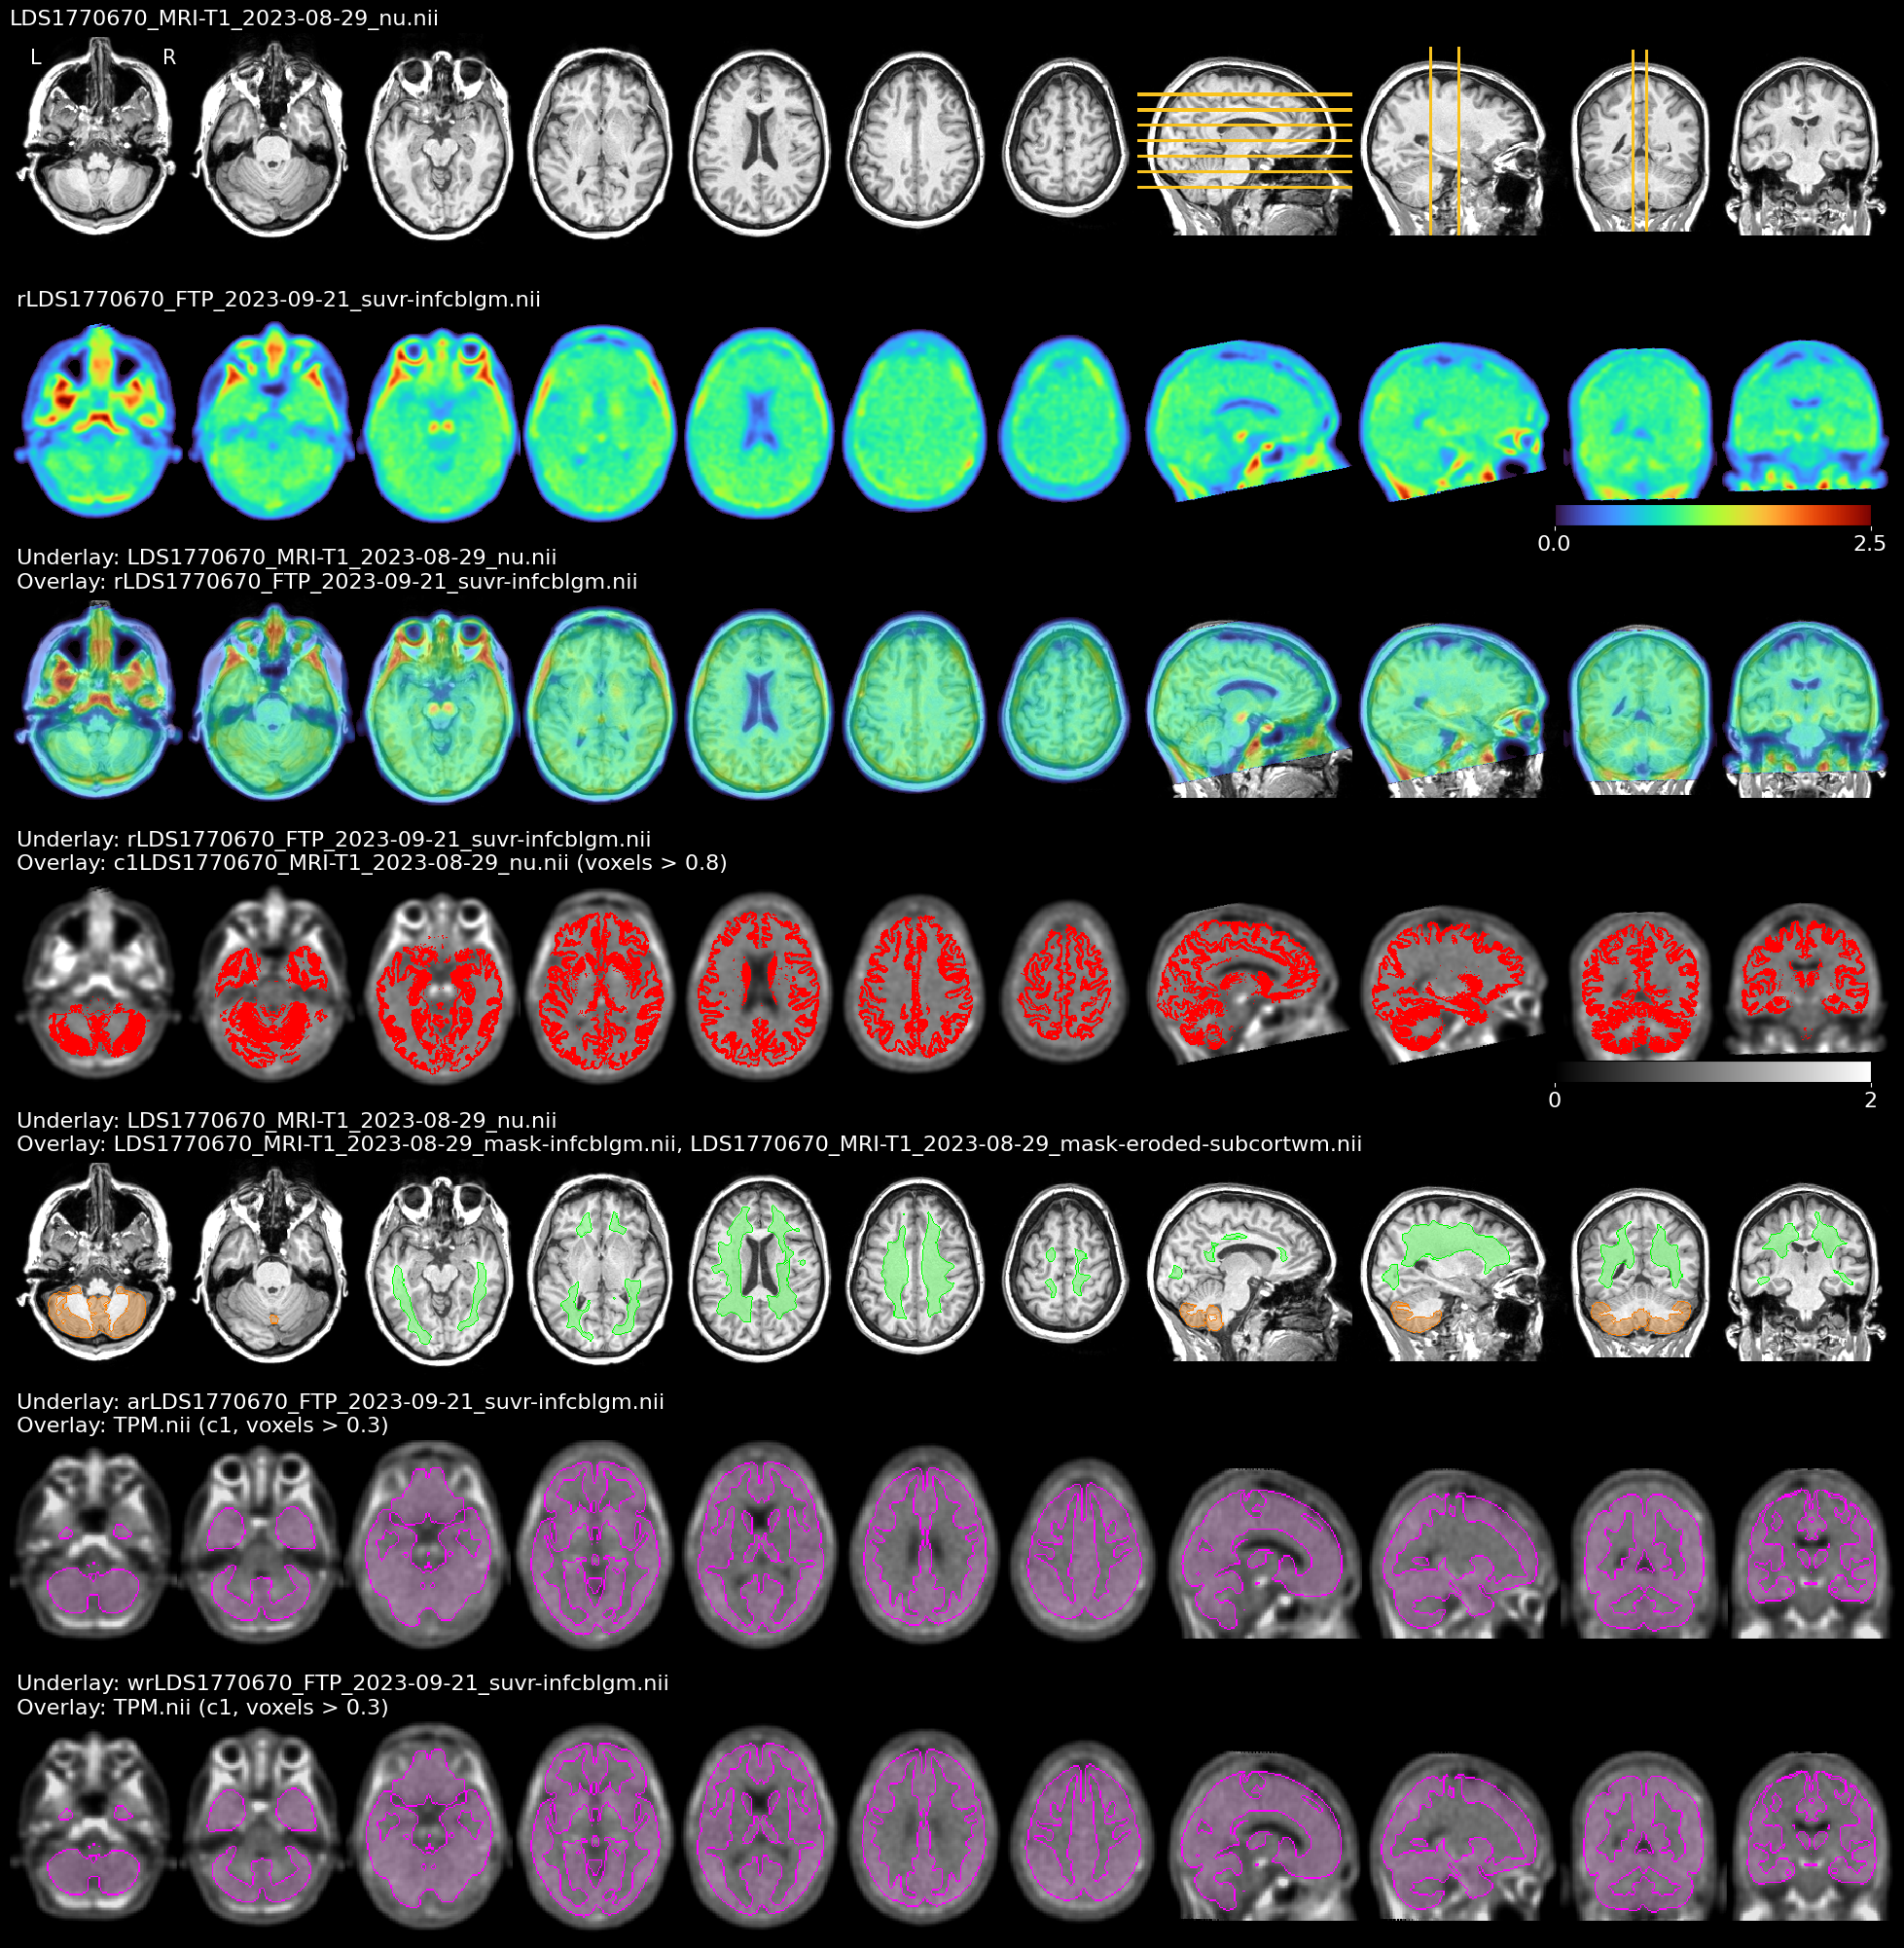

In [7]:
FTPQCplots(suvr_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/FTP_2023-09-21/rLDS1770670_FTP_2023-09-21_suvr-infcblgm.nii',
        axial_slices = select_axial_slices, coronal_slices = select_coronal_slices, sagittal_slices = select_sagittal_slices,
        nu_img= '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_nu.nii',
        aparc_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_aparc+aseg.nii',
        c1_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/c1LDS1770670_MRI-T1_2023-08-29_nu.nii',
        affine_nu_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/aLDS1770670_MRI-T1_2023-08-29_nu.nii',
        warped_nu_img ='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/wLDS1770670_MRI-T1_2023-08-29_nu.nii',
        reference_region_1 = '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_mask-infcblgm.nii',
        reference_region_2 = '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_mask-eroded-subcortwm.nii',
        affine_suvr_img = '/mnt/coredata/processing/leads/data/processed/LDS1770670/FTP_2023-09-21/arLDS1770670_FTP_2023-09-21_suvr-infcblgm.nii',
        warped_suvr_img = '/mnt/coredata/processing/leads/data/processed/LDS1770670/FTP_2023-09-21/wrLDS1770670_FTP_2023-09-21_suvr-infcblgm.nii'
        ).plot_slices('/shared/petcore/Projects/LEADS/data_f7p1/summary/piyush_qc/')


## Generating the FDG images for QC

In [ ]:

FDGQCplots(suvr_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/FDG_2023-11-06/rLDS1770670_FDG_2023-11-06_suvr-pons.nii',
        axial_slices = select_axial_slices, coronal_slices = select_coronal_slices, sagittal_slices = select_sagittal_slices,

        nu_img= '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_nu.nii',
        aparc_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_aparc+aseg.nii',
        c1_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/c1LDS1770670_MRI-T1_2023-08-29_nu.nii',
        affine_nu_img='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/aLDS1770670_MRI-T1_2023-08-29_nu.nii',
        warped_nu_img ='/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/wLDS1770670_MRI-T1_2023-08-29_nu.nii',
        
        reference_region_1 = '/mnt/coredata/processing/leads/data/processed/LDS1770670/MRI-T1_2023-08-29/LDS1770670_MRI-T1_2023-08-29_mask-pons.nii',

        affine_suvr_img = '/mnt/coredata/processing/leads/data/processed/LDS1770670/FDG_2023-11-06/arLDS1770670_FDG_2023-11-06_suvr-pons.nii',
        warped_suvr_img = '/mnt/coredata/processing/leads/data/processed/LDS1770670/FDG_2023-11-06/wrLDS1770670_FDG_2023-11-06_suvr-pons.nii'
        ).plot_slices('/shared/petcore/Projects/LEADS/data_f7p1/summary/piyush_qc/')

